In [1]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [20]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import spectral_norm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
import glob
import matplotlib.image as mpimg

In [8]:

# --------------------------------------
# Hyperparameters (Optimized for SNGAN)
# --------------------------------------
EPOCHS = 550
BATCH_SIZE = 128
IMAGE_SIZE = 32
CHANNELS_IMG = 3
LATENT_DIM = 128
EMBED_DIM = 100  # Increased embedding dimension for better conditioning
LEARNING_RATE = 2e-4
BETA1, BETA2 = 0.0, 0.9
CHECKPOINT_EVERY = 20

In [9]:
# CIFAR-10 class index for "automobile"
AUTOMOBILE_CLASS_IDX = 1

# --------------------------------------
# Data Loading (CIFAR-10) - AUTOMOBILE ONLY
# --------------------------------------
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Filter to get only automobile images
automobile_indices = [i for i, (_, label) in enumerate(full_dataset) if label == AUTOMOBILE_CLASS_IDX]
automobile_dataset = Subset(full_dataset, automobile_indices)


In [10]:
# Create dataloader with only automobile images
trainloader = DataLoader(
    automobile_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2
)

device = torch.device("mps" if torch.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device {device}')

Using device mps


In [11]:
# --------------------------------------
# SNGAN Generator with Improved Conditioning
# --------------------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim, embed_dim):
        super().__init__()
        self.label_emb = nn.Embedding(1, embed_dim)  # Only need one class - automobile
        
        self.fc = nn.Sequential(
            nn.Linear(latent_dim + embed_dim, 4*4*512),
            nn.BatchNorm1d(4*4*512),
            nn.ReLU(True)
        )
        
        # Upsampling to 32x32 with improved architecture
        self.deconv = nn.Sequential(
            # 4x4 -> 8x8
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # 8x8 -> 16x16
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # 16x16 -> 32x32
            nn.ConvTranspose2d(128, CHANNELS_IMG, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z, labels=None):
        # For automobile-only generation, we can use a fixed label
        if labels is None:
            labels = torch.zeros(z.size(0), dtype=torch.long, device=z.device)
            
        label_emb = self.label_emb(labels)
        x = torch.cat([z, label_emb], dim=1)
        x = self.fc(x)
        x = x.view(-1, 512, 4, 4)
        return self.deconv(x)


In [12]:
# --------------------------------------
# SNGAN Discriminator (Spectral Norm) with Improved Conditioning
# --------------------------------------
class Discriminator(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.label_emb = nn.Embedding(1, embed_dim)  # Only need one class - automobile
        
        # Improved discriminator with spectral normalization
        self.conv = nn.Sequential(
            # 32x32 -> 16x16
            spectral_norm(nn.Conv2d(CHANNELS_IMG, 64, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 16x16 -> 8x8
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 8x8 -> 4x4
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 4x4 -> 2x2
            spectral_norm(nn.Conv2d(256, 512, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Final layer with conditioning
        self.fc = spectral_norm(nn.Linear(512*2*2 + embed_dim, 1))

    def forward(self, x, labels=None):
        bsz = x.size(0)
        
        # For automobile-only discrimination, we can use a fixed label
        if labels is None:
            labels = torch.zeros(bsz, dtype=torch.long, device=x.device)
            
        features = self.conv(x).view(bsz, -1)
        label_emb = self.label_emb(labels)
        combined = torch.cat([features, label_emb], dim=1)
        return self.fc(combined)

In [13]:
# --------------------------------------
# Initialize Models & Optimizers
# --------------------------------------
gen = Generator(LATENT_DIM, EMBED_DIM).to(device)
disc = Discriminator(EMBED_DIM).to(device)
criterion = nn.BCEWithLogitsLoss()

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

In [14]:
# Checkpoint loading
start_epoch = 1
checkpoint_path = "adl_part2.pt"
# --------------------------------------
# Check for Existing Checkpoint
# --------------------------------------
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    gen.load_state_dict(checkpoint["gen_state_dict"])
    disc.load_state_dict(checkpoint["disc_state_dict"])
    opt_gen.load_state_dict(checkpoint["opt_gen_state_dict"])
    opt_disc.load_state_dict(checkpoint["opt_disc_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Loaded checkpoint from epoch {start_epoch-1}")

Loaded checkpoint from epoch 500


In [15]:
# --------------------------------------
# Utility: Generate & Show 10 Samples
# --------------------------------------
def generate_and_show_samples(epoch):
    gen.eval()
    with torch.no_grad():
        z = torch.randn(10, LATENT_DIM, device=device)
        # No need to specify labels since we're only generating automobiles
        samples = gen(z).cpu()
    samples = (samples + 1) / 2.0
    fig, axes = plt.subplots(1, 10, figsize=(22, 2.4))
    for i in range(10):
        img = samples[i].permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.suptitle(f"Epoch {epoch}: Generated Automobiles", fontsize=14)
    plt.savefig(f"automobile_samples_epoch_{epoch}.png")
    plt.show()
    gen.train()

In [16]:
# --------------------------------------
# Compute IS & FID with TorchMetrics
# --------------------------------------
def compute_is_fid(generator, loader, n_samples=2000):
    is_metric = InceptionScore().to("cpu")
    fid_metric = FrechetInceptionDistance().to("cpu")
    generator.eval()

    real_count = 0
    for real_imgs, _ in loader:
        real_imgs = real_imgs.to(device)
        real_imgs_uint8 = (((real_imgs * 0.5) + 0.5) * 255).to(torch.uint8).cpu()
        fid_metric.update(real_imgs_uint8, real=True)
        real_count += real_imgs.size(0)
        if real_count >= n_samples:
            break

    fake_count = 0
    with torch.no_grad():
        while fake_count < n_samples:
            z = torch.randn(min(BATCH_SIZE, n_samples - fake_count), LATENT_DIM, device=device)
            fake_out = generator(z)
            fake_out_uint8 = (((fake_out * 0.5) + 0.5) * 255).to(torch.uint8).cpu()
            is_metric.update(fake_out_uint8)
            fid_metric.update(fake_out_uint8, real=False)
            fake_count += z.size(0)

    inception_score = is_metric.compute()  # (mean, std)
    fid_score = fid_metric.compute()
    generator.train()
    return inception_score[0].item(), fid_score.item()

[Epoch 501/550]  LossD: 1.2422  LossG: 0.8610
[Epoch 502/550]  LossD: 1.2375  LossG: 0.8608
[Epoch 503/550]  LossD: 1.2366  LossG: 0.8723
[Epoch 504/550]  LossD: 1.2385  LossG: 0.8631
[Epoch 505/550]  LossD: 1.2430  LossG: 0.8634
[Epoch 506/550]  LossD: 1.2413  LossG: 0.8667
[Epoch 507/550]  LossD: 1.2389  LossG: 0.8611
[Epoch 508/550]  LossD: 1.2348  LossG: 0.8667
[Epoch 509/550]  LossD: 1.2404  LossG: 0.8688
[Epoch 510/550]  LossD: 1.2421  LossG: 0.8608
[Epoch 511/550]  LossD: 1.2417  LossG: 0.8590
[Epoch 512/550]  LossD: 1.2413  LossG: 0.8607
[Epoch 513/550]  LossD: 1.2391  LossG: 0.8620
[Epoch 514/550]  LossD: 1.2373  LossG: 0.8610
[Epoch 515/550]  LossD: 1.2384  LossG: 0.8672
[Epoch 516/550]  LossD: 1.2381  LossG: 0.8715
[Epoch 517/550]  LossD: 1.2483  LossG: 0.8597
[Epoch 518/550]  LossD: 1.2396  LossG: 0.8585
[Epoch 519/550]  LossD: 1.2393  LossG: 0.8665
[Epoch 520/550]  LossD: 1.2391  LossG: 0.8650
[epoch=520] Checkpoint saved: adl_part2.pt


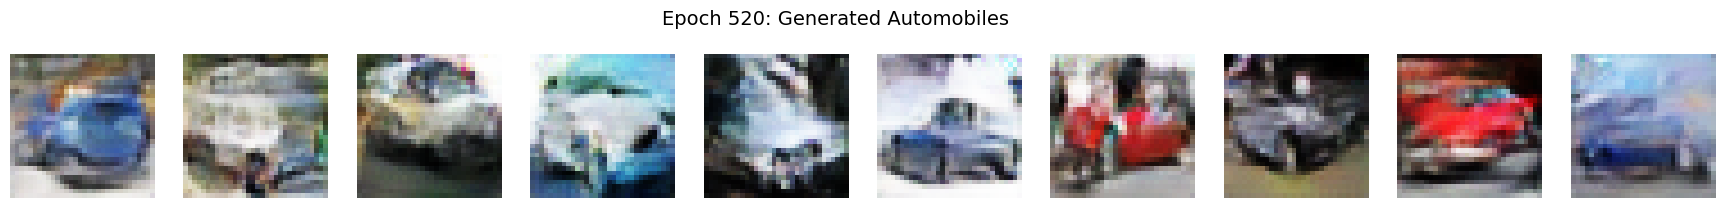

/Users/shivamsahil/Downloads/bits/assignments/venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


==> Epoch 520: Inception Score = 3.0748, FID = 83.1932
[Epoch 521/550]  LossD: 1.2403  LossG: 0.8559
[Epoch 522/550]  LossD: 1.2426  LossG: 0.8677
[Epoch 523/550]  LossD: 1.2364  LossG: 0.8648
[Epoch 524/550]  LossD: 1.2446  LossG: 0.8790
[Epoch 525/550]  LossD: 1.2414  LossG: 0.8541
[Epoch 526/550]  LossD: 1.2367  LossG: 0.8642
[Epoch 527/550]  LossD: 1.2351  LossG: 0.8661
[Epoch 528/550]  LossD: 1.2436  LossG: 0.8595
[Epoch 529/550]  LossD: 1.2361  LossG: 0.8591
[Epoch 530/550]  LossD: 1.2425  LossG: 0.8593
[Epoch 531/550]  LossD: 1.2403  LossG: 0.8597
[Epoch 532/550]  LossD: 1.2382  LossG: 0.8658
[Epoch 533/550]  LossD: 1.2399  LossG: 0.8597
[Epoch 534/550]  LossD: 1.2350  LossG: 0.8632
[Epoch 535/550]  LossD: 1.2372  LossG: 0.8640
[Epoch 536/550]  LossD: 1.2392  LossG: 0.8557
[Epoch 537/550]  LossD: 1.2438  LossG: 0.8636
[Epoch 538/550]  LossD: 1.2390  LossG: 0.8611
[Epoch 539/550]  LossD: 1.2391  LossG: 0.8711
[Epoch 540/550]  LossD: 1.2337  LossG: 0.8539
[epoch=540] Checkpoint sa

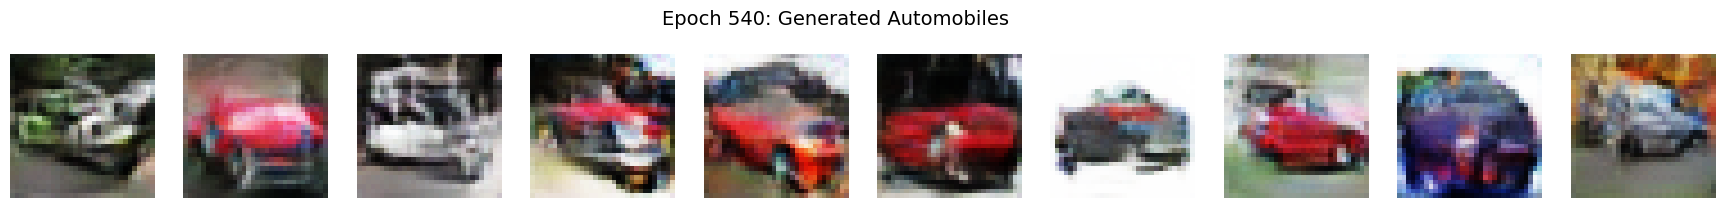

==> Epoch 540: Inception Score = 3.1830, FID = 75.2091
[Epoch 541/550]  LossD: 1.2420  LossG: 0.8673
[Epoch 542/550]  LossD: 1.2424  LossG: 0.8556
[Epoch 543/550]  LossD: 1.2356  LossG: 0.8577
[Epoch 544/550]  LossD: 1.2357  LossG: 0.8613
[Epoch 545/550]  LossD: 1.2385  LossG: 0.8711
[Epoch 546/550]  LossD: 1.2392  LossG: 0.8536
[Epoch 547/550]  LossD: 1.2412  LossG: 0.8608
[Epoch 548/550]  LossD: 1.2398  LossG: 0.8599
[Epoch 549/550]  LossD: 1.2420  LossG: 0.8645
[Epoch 550/550]  LossD: 1.2401  LossG: 0.8617
Training complete!


In [18]:
# --------------------------------------
# Training
# --------------------------------------
g_losses, d_losses = [], []
for epoch in range(start_epoch, EPOCHS + 1):
    epoch_g_losses, epoch_d_losses = [], []
    
    for _, (real, _) in enumerate(trainloader):
        real = real.to(device)
        bsz = real.size(0)

        # Train Discriminator
        disc.zero_grad()
        noise = torch.randn(bsz, LATENT_DIM, device=device)
        
        # Real images (all are automobiles)
        pred_real = disc(real)
        loss_real = criterion(pred_real, torch.ones_like(pred_real))

        # Fake images
        fake = gen(noise)
        pred_fake = disc(fake.detach())
        loss_fake = criterion(pred_fake, torch.zeros_like(pred_fake))

        lossD = loss_real + loss_fake
        lossD.backward()
        opt_disc.step()
        epoch_d_losses.append(lossD.item())

        # Train Generator
        gen.zero_grad()
        pred_gen = disc(fake)
        lossG = criterion(pred_gen, torch.ones_like(pred_gen))
        lossG.backward()
        opt_gen.step()
        epoch_g_losses.append(lossG.item())

    # Calculate average losses for the epoch
    avg_g_loss = sum(epoch_g_losses) / len(epoch_g_losses)
    avg_d_loss = sum(epoch_d_losses) / len(epoch_d_losses)
    g_losses.append(avg_g_loss)
    d_losses.append(avg_d_loss)
    
    print(f"[Epoch {epoch}/{EPOCHS}]  LossD: {avg_d_loss:.4f}  LossG: {avg_g_loss:.4f}")

    # Save, visualize, compute IS/FID at checkpoints
    if epoch % CHECKPOINT_EVERY == 0:
        data_to_save = {
            "epoch": epoch,
            "gen_state_dict": gen.state_dict(),
            "disc_state_dict": disc.state_dict(),
            "opt_gen_state_dict": opt_gen.state_dict(),
            "opt_disc_state_dict": opt_disc.state_dict(),
            "g_losses": g_losses,
            "d_losses": d_losses
        }
        torch.save(data_to_save, checkpoint_path)
        print(f"[epoch={epoch}] Checkpoint saved: {checkpoint_path}")
        generate_and_show_samples(epoch)
        
        # Compute metrics
        try:
            is_val, fid_val = compute_is_fid(gen, trainloader)
            print(f"==> Epoch {epoch}: Inception Score = {is_val:.4f}, FID = {fid_val:.4f}")
        except Exception as e:
            print(f"Error computing metrics: {e}")
print("Training complete!")

#### Display all Results at checkpoints

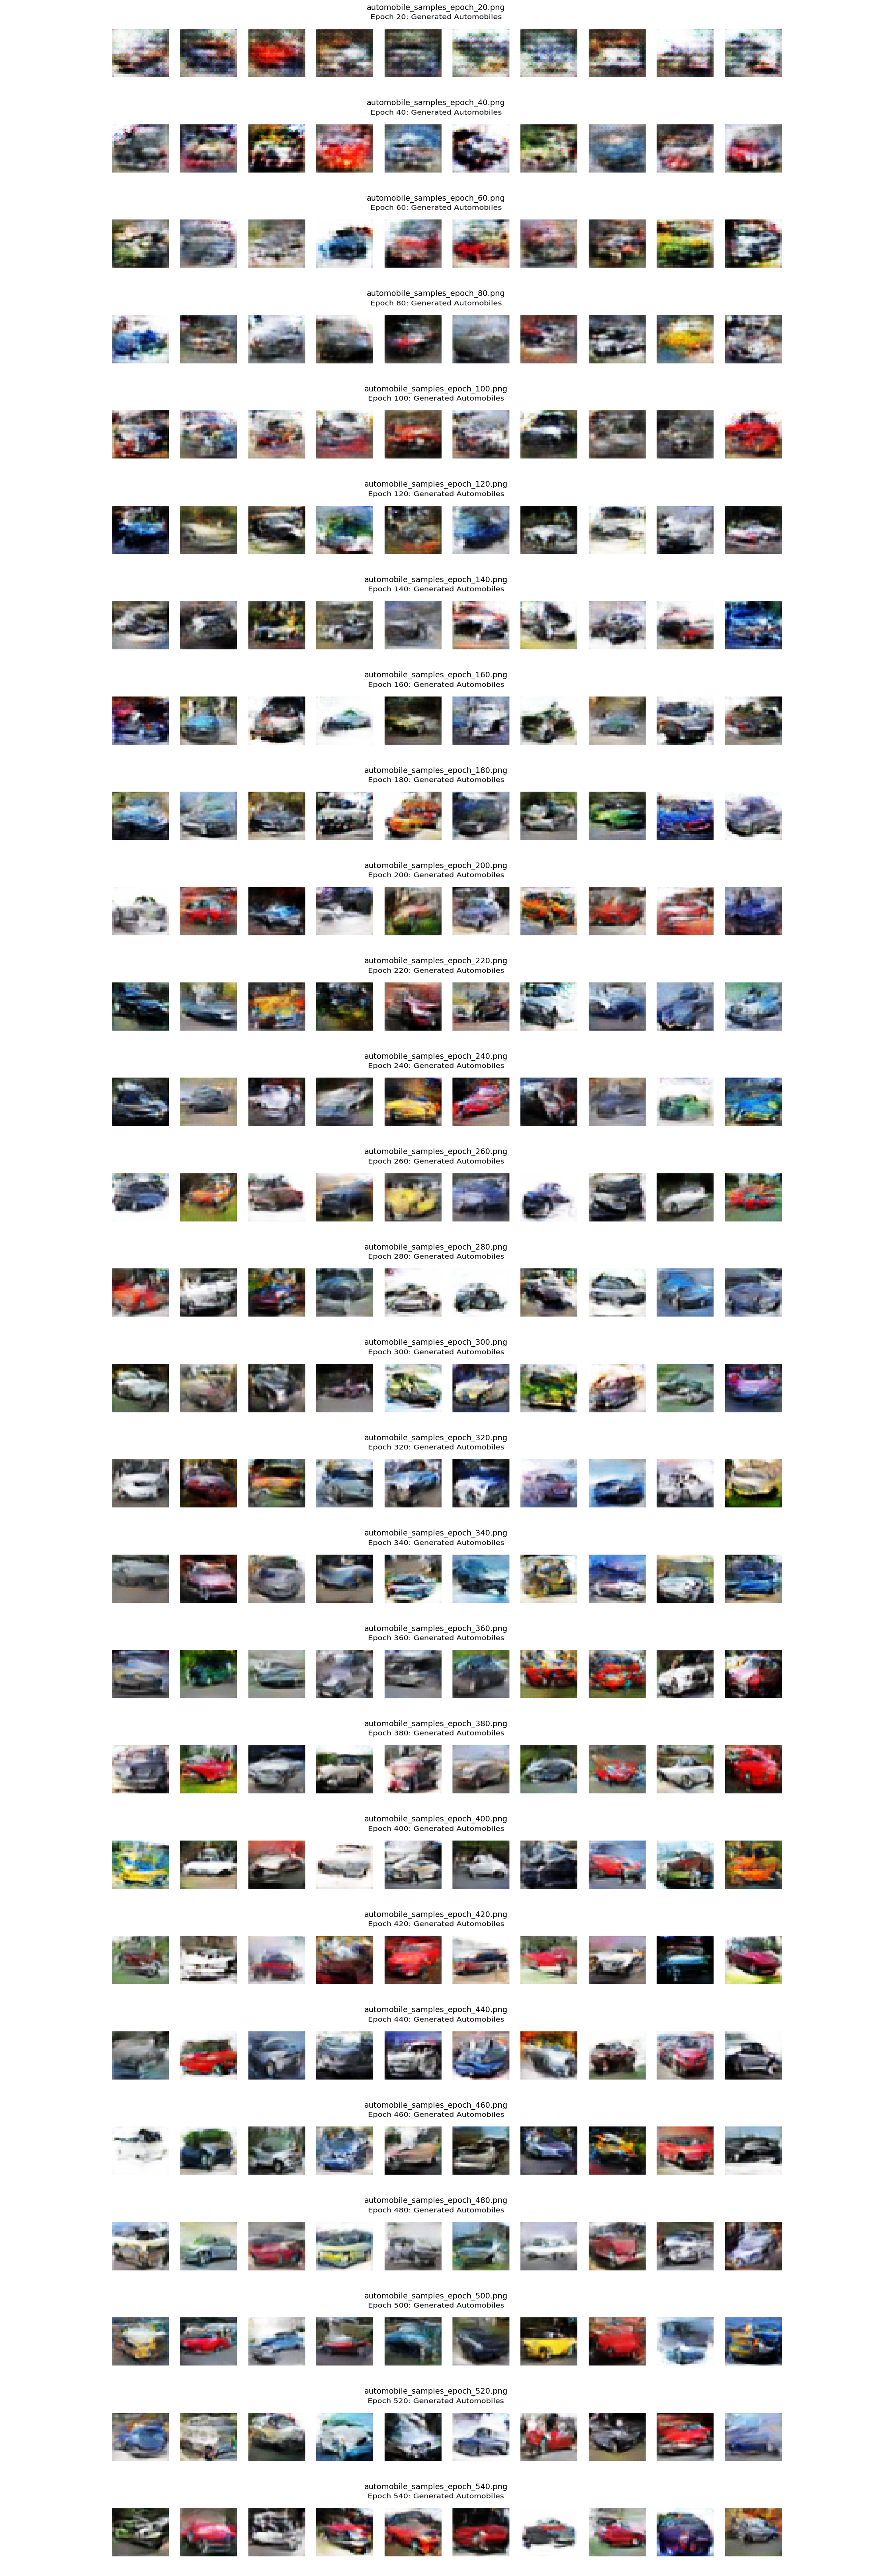

In [28]:
directory = r'task2'
# Define a custom sort key that extracts the epoch number
def extract_epoch(filename):
    base = os.path.basename(filename)
    try:
        # Assuming filename format: automobile_samples_epoch_{epoch_number}.png
        epoch_str = base.split('automobile_samples_epoch_')[1].split('.')[0]
        return int(epoch_str)
    except (IndexError, ValueError):
        return float('inf')  # Place any files that don't match the pattern at the end
png_files = glob.glob(os.path.join(directory, '*.png'))
# Sort the list numerically by epoch number
png_files = sorted(png_files, key=extract_epoch)

# Check if any PNG files are found
if not png_files:
    print("No PNG files found in the directory:", directory)
else:
    n = len(png_files)
    
    # Increase the figure size to accommodate full screen-like display
    fig, axs = plt.subplots(n, 1, figsize=(22, 2.4 * n))
    
    # If only one image, wrap axs into a list for consistency
    if n == 1:
        axs = [axs]

    # Attempt to maximize the figure window (works on some backends)
    mng = plt.get_current_fig_manager()
    try:
        # This works for some backends (e.g., TkAgg on Windows)
        mng.window.state('zoomed')
    except AttributeError:
        try:
            # Alternative for other backends (e.g., Qt)
            mng.window.showMaximized()
        except Exception:
            pass  # If it fails, the figure will remain at the set figsize

    # Loop through each file and display the image
    for ax, file in zip(axs, png_files):
        img = mpimg.imread(file)
        ax.imshow(img, aspect='auto')
        ax.axis('off')
        ax.set_title(os.path.basename(file), fontsize=14)
    
    plt.tight_layout()
    plt.show()